
# Pinch Detection Lab — Wrist Accelerometer (Energy-Envelope Method)

This notebook lets you **experiment** with wrist accelerometer recordings to design a robust **pinch detector**.  
It implements the end-to-end pipeline we discussed:

1. Load recordings (stationary with pinches, and a walking baseline)
2. Combine axes to a magnitude and remove gravity
3. Estimate sampling rate automatically
4. Inspect spectrum (Welch PSD) to spot the pinch band
5. Filter (band-pass via HP→LP), then compute **energy envelope**
6. Adaptive thresholding with hysteresis and refractory
7. Visualize, tune parameters, and export detected events

> By default the notebook points to your uploaded files: `/mnt/data/WristMotion.csv` and `/mnt/data/WristMotion Walking.csv`.
>
> **Tip:** If auto-detection of columns or sampling rate fails, scroll to the **Parameters** cell and set them explicitly.


In [46]:

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

try:
    from scipy import signal
    SCIPY_OK = True
except Exception as e:
    SCIPY_OK = False
    print("SciPy not available. Falling back to simple 1-pole filters for HP/LP.")
    
# Ensure inline plots
# (No seaborn, no styles, and we'll avoid subplots per instructions)


## File paths

In [47]:

# Update these if your files are elsewhere
STATIONARY_PATH = "~/Downloads/WristMotion.csv"
WALKING_PATH = "~/Downloads/WristMotion%20Walking.csv"


## Helpers — Load data, detect columns, estimate sampling rate

In [48]:
def _guess_time_col(df):
    # Prefer obvious names
    candidates = [c for c in df.columns if str(c).lower() in 
                  ["time","timestamp","ts","t","date","datetime","elapsed","elapsed_s","seconds","seconds_elapsed"]]
    for c in candidates:
        return c
    # Else look for a monotonic numeric column with many unique values
    for c in df.columns:
        s = df[c]
        if np.issubdtype(s.dtype, np.number) and s.nunique() > max(10, len(s)//10):
            # check if mostly increasing
            diffs = np.diff(s.values.astype(float))
            if np.nanmedian(diffs) > 0:
                return c
    return None

def _normalize_time_series(t_raw):
    """Return time in seconds and a best-effort sampling rate fs."""
    t = np.asarray(t_raw).astype(float)
    # If looks like epoch ms/us, normalize to seconds by median diff scale
    diffs = np.diff(t)
    diffs = diffs[np.isfinite(diffs) & (diffs > 0)]
    if len(diffs) == 0:
        # Build index-based time with default fs
        fs = 100.0
        t = np.arange(len(t_raw)) / fs
        return t, fs
    
    md = np.nanmedian(diffs)
    if md <= 0:
        # Build index-based time with default fs  
        fs = 100.0
        t = np.arange(len(t_raw)) / fs
        return t, fs
        
    # Decide unit scale by size of median diff
    # seconds if ~[1e-4, 10], milliseconds if ~[10, 5000], microseconds if bigger
    if 1e-4 <= md <= 10:
        scale = 1.0   # already seconds
    elif 10 < md <= 5000:
        scale = 1e-3  # probably milliseconds
    elif 5000 < md <= 5e6:
        scale = 1e-6  # probably microseconds
    else:
        # fallback: assume index-based timing
        fs = 100.0
        t = np.arange(len(t_raw)) / fs
        return t, fs
        
    t = t * scale
    diffs = np.diff(t)
    diffs = diffs[np.isfinite(diffs) & (diffs>0)]
    if len(diffs) == 0:
        fs = 100.0
    else:
        fs = 1.0 / np.nanmedian(diffs)
        # Sanity check on fs
        if fs <= 0 or fs > 1000:
            fs = 100.0
    return t, fs

def _guess_axes_cols(df):
    # Look for typical names first
    lower = {c: str(c).lower() for c in df.columns}
    name_map = {}
    
    for c, lc in lower.items():
        if any(pattern in lc for pattern in ["useraccelerationx", "accelx", "acc_x", "acceleration_x"]) or lc == "x":
            name_map["ax"] = c
        elif any(pattern in lc for pattern in ["useraccelerationy", "accely", "acc_y", "acceleration_y"]) or lc == "y":
            name_map["ay"] = c
        elif any(pattern in lc for pattern in ["useraccelerationz", "accelz", "acc_z", "acceleration_z"]) or lc == "z":
            name_map["az"] = c
            
    if set(["ax","ay","az"]).issubset(name_map):
        return name_map["ax"], name_map["ay"], name_map["az"]
    
    # Fallback: pick three numeric columns with highest variance, excluding time columns
    time_candidates = [c for c in df.columns if str(c).lower() in 
                      ["time","timestamp","ts","t","date","datetime","elapsed","elapsed_s","seconds","seconds_elapsed"]]
    num_cols = [c for c in df.columns if np.issubdtype(df[c].dtype, np.number) and c not in time_candidates]
    
    if len(num_cols) >= 3:
        variances = sorted([(df[c].var(), c) for c in num_cols], reverse=True)
        top3 = [c for _, c in variances[:3]]
        print(f"Warning: Guessing accelerometer columns from highest variance: {top3}")
        return top3[0], top3[1], top3[2]
    
    raise ValueError("Could not identify accelerometer axis columns. Please rename columns to x,y,z or set manually.")

def load_accel(filepath, time_col=None, ax=None, ay=None, az=None):
    try:
        df = pd.read_csv(filepath)
        print(f"Loaded {filepath} with columns: {list(df.columns)}")
    except Exception as e:
        print(f"Error loading file {filepath}: {e}")
        raise
    
    if time_col is None:
        time_col = _guess_time_col(df)
        if time_col:
            print(f"Auto-detected time column: {time_col}")
    
    if ax is None or ay is None or az is None:
        try:
            ax_g, ay_g, az_g = _guess_axes_cols(df)
            ax = ax or ax_g
            ay = ay or ay_g
            az = az or az_g
            print(f"Auto-detected axis columns: X={ax}, Y={ay}, Z={az}")
        except Exception as e:
            print(f"Error detecting columns: {e}")
            raise
    
    # Build time
    if time_col is not None and time_col in df.columns:
        t_raw = df[time_col].values
        t, fs = _normalize_time_series(t_raw)
        print(f"Calculated sampling rate: {fs:.2f} Hz")
    else:
        fs = 100.0
        t = np.arange(len(df)) / fs
        print(f"Using default time axis at {fs} Hz")
    
    # Extract axes as float
    try:
        X = df[[ax, ay, az]].astype(float).copy()
        X.columns = ["ax","ay","az"]
        # Magnitude
        m = np.sqrt((X**2).sum(axis=1)).values
        print(f"Successfully loaded {len(df)} samples, magnitude range: {m.min():.3f} to {m.max():.3f}")
    except Exception as e:
        print(f"Error processing accelerometer data: {e}")
        raise
    
    return {"df": df, "time": t, "fs": fs, "axes": X, "mag": m, "time_col": time_col, "ax_names": (ax, ay, az)}

## Filters — HP/LP (Butterworth) + fallbacks if SciPy missing

In [49]:
def butter_hp(signal_in, fs, fc=4.0, order=2):
    x = np.asarray(signal_in).astype(float)
    if fs <= 0:
        print(f"Warning: Invalid sampling rate {fs}, using fallback filter")
        fs = 100.0
        
    if SCIPY_OK and fc < fs/2.0:
        try:
            b, a = signal.butter(order, fc/(fs/2.0), btype="highpass")
            return signal.filtfilt(b, a, x)
        except Exception as e:
            print(f"Butterworth HP filter failed: {e}, using fallback")
    
    # 1-pole HP fallback
    alpha = math.exp(-2.0*math.pi*fc/fs)
    y = np.zeros_like(x)
    for n in range(1, len(x)):
        y[n] = alpha*(y[n-1] + x[n] - x[n-1])
    return y

def butter_lp(signal_in, fs, fc=18.0, order=2):
    x = np.asarray(signal_in).astype(float)
    if fs <= 0:
        print(f"Warning: Invalid sampling rate {fs}, using fallback filter")
        fs = 100.0
        
    if SCIPY_OK and fc < fs/2.0:
        try:
            b, a = signal.butter(order, fc/(fs/2.0), btype="lowpass")
            return signal.filtfilt(b, a, x)
        except Exception as e:
            print(f"Butterworth LP filter failed: {e}, using fallback")
    
    # 1-pole LP fallback
    beta = 1.0 - math.exp(-2.0*math.pi*fc/fs)
    y = np.zeros_like(x)
    for n in range(len(x)):
        y[n] = beta*x[n] + (1.0-beta)*(y[n-1] if n>0 else x[n])
    return y

def remove_gravity(mag, fs, fc=0.5):
    if fs <= 0:
        print(f"Warning: Invalid sampling rate {fs} for gravity removal, using fallback")
        fs = 100.0
        
    if SCIPY_OK and fc < fs/2.0:
        try:
            b, a = signal.butter(2, fc/(fs/2.0), btype="lowpass")
            g = signal.filtfilt(b, a, mag)
            return mag - g, g
        except Exception as e:
            print(f"Butterworth gravity filter failed: {e}, using fallback")
    
    # 1-pole LP estimate of gravity fallback
    beta = 1.0 - math.exp(-2.0*math.pi*fc/fs)
    g = np.zeros_like(mag)
    for n in range(len(mag)):
        g[n] = beta*mag[n] + (1.0-beta)*(g[n-1] if n>0 else mag[n])
    return mag - g, g

## PSD — Welch spectrum to locate the pinch band

In [50]:

def welch_psd(x, fs):
    if SCIPY_OK:
        f, Pxx = signal.welch(x, fs=fs, nperseg=min(1024, max(256, len(x)//4)))
    else:
        # Simple periodogram fallback
        n = len(x)
        X = np.fft.rfft(x*np.hanning(n))
        Pxx = (1.0/(fs*n)) * np.abs(X)**2
        f = np.fft.rfftfreq(n, d=1/fs)
    return f, Pxx

def estimate_pinch_peak(x, fs, fmin=3.5, fmax=25.0):
    f, Pxx = welch_psd(x, fs)
    mask = (f>=fmin) & (f<=fmax)
    if not np.any(mask):
        return None, (f, Pxx)
    idx = np.argmax(Pxx[mask])
    fpeak = f[mask][idx]
    return float(fpeak), (f, Pxx)


## Energy envelope, adaptive thresholds, hysteresis + refractory

In [51]:

def ema(x, fs, tau):
    alpha = 1.0 - math.exp(-1.0/(fs*tau))
    y = np.zeros_like(x, dtype=float)
    for n in range(len(x)):
        y[n] = alpha*x[n] + (1.0-alpha)*(y[n-1] if n>0 else x[n])
    return y

def energy_envelope(y, fs, method="ema", M=None, tau=0.2):
    z = y*y
    if method == "ma":
        if M is None:
            M = max(1, int(round(0.2*fs)))
        # Moving average via convolution
        k = np.ones(M, dtype=float) / float(M)
        e = np.convolve(z, k, mode="same")
        return e
    # default EMA
    return ema(z, fs, tau=tau)

def adaptive_thresholds(e, fs, tau_b=2.0, tau_v=2.0, k_hi=4.0, k_lo=2.5):
    b = ema(e, fs, tau_b)                         # baseline
    v = ema(np.abs(e - b), fs, tau_v)             # robust variability proxy
    T_hi = b + k_hi * v
    T_lo = b + k_lo * v
    return b, v, T_hi, T_lo

def detect_events(e, t, T_hi, T_lo, refractory=0.30, min_duration=0.10):
    events_idx = []
    in_active = False
    last_fire_t = -1e9
    start_above_t = None
    for n in range(len(e)):
        if not in_active:
            if e[n] > T_hi[n] and (t[n] - last_fire_t) >= refractory:
                in_active = True
                start_above_t = t[n]
        else:
            if e[n] < T_lo[n]:
                in_active = False
                start_above_t = None
        # Confirm pinch
        if in_active and start_above_t is not None:
            if (t[n] - start_above_t) >= min_duration:
                # Fire once at first qualifying sample
                events_idx.append(n)
                last_fire_t = t[n]
                in_active = False
                start_above_t = None
    return np.array(events_idx, dtype=int)


## End-to-end pipeline

In [52]:
def run_pipeline(record, hp_cut=4.0, lp_cut=18.0, env_method="ema", env_tau=0.2, env_M=None,
                 tau_b=2.0, tau_v=2.0, k_hi=4.0, k_lo=2.5, refractory=0.30, min_duration=0.10,
                 gravity_fc=0.5, show_plots=True, label=""):
    t = record["time"]
    fs = record["fs"]
    m = record["mag"]
    m_lin, g = remove_gravity(m, fs, fc=gravity_fc)
    # Band-pass (HP then LP)
    y = butter_hp(m_lin, fs, fc=hp_cut, order=2)
    y = butter_lp(y, fs, fc=lp_cut, order=2)
    # Envelope
    e = energy_envelope(y, fs, method=env_method, M=env_M, tau=env_tau)
    b, v, T_hi, T_lo = adaptive_thresholds(e, fs, tau_b=tau_b, tau_v=tau_v, k_hi=k_hi, k_lo=k_lo)
    events_idx = detect_events(e, t, T_hi, T_lo, refractory=refractory, min_duration=min_duration)
    events_t = t[events_idx] if len(events_idx) else np.array([])

    if show_plots:
        # Plot raw magnitude & gravity estimate
        plt.figure()
        plt.title(f"Raw magnitude & gravity estimate {label}")
        plt.plot(t, m, label="|a|")
        plt.plot(t, g, label="gravity (LP)")
        plt.xlabel("Time [s]")
        plt.ylabel("Accel (units)")
        plt.legend()

        # PSD of gravity-removed magnitude
        f, Pxx = welch_psd(m_lin, fs)
        plt.figure()
        plt.title(f"Welch PSD (gravity-removed magnitude) {label}")
        plt.semilogy(f, Pxx)
        plt.xlabel("Frequency [Hz]")
        plt.ylabel("PSD")

        # Filtered band-passed signal with event markers
        plt.figure()
        plt.title(f"Band-passed signal with detected events {label}")
        plt.plot(t, y, label="band-passed signal")
        if len(events_t):
            plt.scatter(events_t, y[events_idx], color='red', marker='x', s=100, label=f"events ({len(events_t)})")
        plt.xlabel("Time [s]")
        plt.ylabel("BP amplitude")
        plt.legend()

        # Envelope + thresholds + events
        plt.figure()
        plt.title(f"Envelope with thresholds {label}")
        plt.plot(t, e, label="envelope")
        plt.plot(t, T_hi, label="T_hi")
        plt.plot(t, T_lo, label="T_lo")
        if len(events_t):
            plt.scatter(events_t, e[events_idx], marker="x", label="events")
        plt.xlabel("Time [s]")
        plt.ylabel("Energy")
        plt.legend()

    summary = {
        "fs": fs,
        "n_samples": len(t),
        "duration_s": float(t[-1]-t[0]) if len(t) else 0.0,
        "n_events": int(len(events_idx)),
        "events_sec": events_t.tolist(),
    }
    return {"t": t, "fs": fs, "m": m, "g": g, "m_lin": m_lin, "y": y, "e": e,
            "b": b, "v": v, "T_hi": T_hi, "T_lo": T_lo,
            "events_idx": events_idx, "events_t": events_t, "summary": summary}


## Parameters — edit here

Suggested defaults for pinch detection:
- High-pass cutoff `hp_cut = 4 Hz` (remove steps/arm swing)
- Low-pass cutoff `lp_cut = 18 Hz` (remove hiss)
- Envelope via EMA with `env_tau = 0.2 s`
- Adaptive baselines `tau_b = tau_v = 2.0 s`
- Hysteresis `k_hi = 4.0`, `k_lo = 2.5`
- Refractory `0.30 s`, min duration `0.10 s`


In [53]:

hp_cut = 4.0
lp_cut = 18.0
env_method = "ema"   # "ema" or "ma"
env_tau = 0.20       # used if method == "ema"
env_M = None         # used if method == "ma" (samples); None -> 0.2 s window

tau_b = 2.0
tau_v = 2.0
k_hi = 4.0
k_lo = 2.5
refractory = 0.30
min_duration = 0.10

gravity_fc = 0.5


## Load the recordings

In [54]:

stationary = load_accel(STATIONARY_PATH)
walking = load_accel(WALKING_PATH)

print("Stationary file summary:")
print("  fs      =", round(stationary["fs"], 3), "Hz")
print("  samples =", len(stationary["time"]))
print("  duration=", round(stationary["time"][-1]-stationary["time"][0], 3), "s")
print("  axes    =", stationary["ax_names"], "time_col =", stationary["time_col"])

print("\nWalking file summary:")
print("  fs      =", round(walking["fs"], 3), "Hz")
print("  samples =", len(walking["time"]))
print("  duration=", round(walking["time"][-1]-walking["time"][0], 3), "s")
print("  axes    =", walking["ax_names"], "time_col =", walking["time_col"])


Loaded ~/Downloads/WristMotion.csv with columns: ['time', 'seconds_elapsed', 'rotationRateX', 'rotationRateY', 'rotationRateZ', 'gravityX', 'gravityY', 'gravityZ', 'accelerationX', 'accelerationY', 'accelerationZ', 'quaternionW', 'quaternionX', 'quaternionY', 'quaternionZ', 'pitch', 'roll', 'yaw']
Auto-detected time column: time
Auto-detected axis columns: X=rotationRateX, Y=rotationRateY, Z=rotationRateZ
Calculated sampling rate: 100.00 Hz
Successfully loaded 2966 samples, magnitude range: 0.001 to 0.572
Loaded ~/Downloads/WristMotion%20Walking.csv with columns: ['time', 'seconds_elapsed', 'rotationRateX', 'rotationRateY', 'rotationRateZ', 'gravityX', 'gravityY', 'gravityZ', 'accelerationX', 'accelerationY', 'accelerationZ', 'quaternionW', 'quaternionX', 'quaternionY', 'quaternionZ', 'pitch', 'roll', 'yaw']
Auto-detected time column: time
Auto-detected axis columns: X=rotationRateZ, Y=rotationRateX, Z=rotationRateY
Calculated sampling rate: 100.00 Hz
Successfully loaded 11459 samples,

## Estimate pinch frequency peak from stationary recording

Estimated pinch peak frequency ≈ 3.64 Hz


Text(0, 0.5, 'PSD')

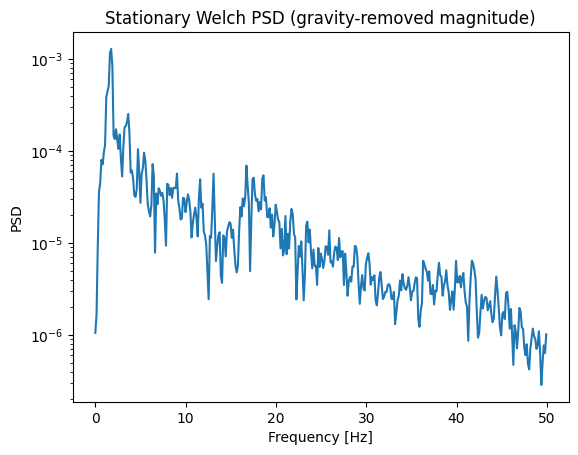

In [55]:

fpeak, psd_data = estimate_pinch_peak(stationary["mag"] - remove_gravity(stationary["mag"], stationary["fs"], gravity_fc)[1], 
                                      stationary["fs"], fmin=3.5, fmax=25.0)
if fpeak is not None:
    print("Estimated pinch peak frequency ≈", round(fpeak, 2), "Hz")
    # Optionally adjust default passband around peak
    # hp_cut = max(3.5, 0.6 * fpeak)
    # lp_cut = min(25.0, 1.6 * fpeak)
else:
    print("Could not find a clear peak in 3.5–25 Hz; keeping default HP/LP.")
    
# Plot PSD of the stationary gravity-removed magnitude
f, Pxx = psd_data
plt.figure()
plt.title("Stationary Welch PSD (gravity-removed magnitude)")
plt.semilogy(f, Pxx)
plt.xlabel("Frequency [Hz]")
plt.ylabel("PSD")


## Run the detection pipeline


Stationary summary: {'fs': 100.0, 'n_samples': 2966, 'duration_s': 29.65, 'n_events': 10, 'events_sec': [0.13, 0.53, 1.23, 1.64, 10.49, 18.35, 25.34, 26.17, 27.53, 29.14]}
Walking summary: {'fs': 100.0, 'n_samples': 11459, 'duration_s': 114.58, 'n_events': 17, 'events_sec': [0.11, 0.51, 0.92, 1.56, 13.97, 22.75, 23.32, 34.24, 57.56, 66.65, 74.22, 74.64, 90.5, 93.84, 108.23, 113.11, 114.12]}


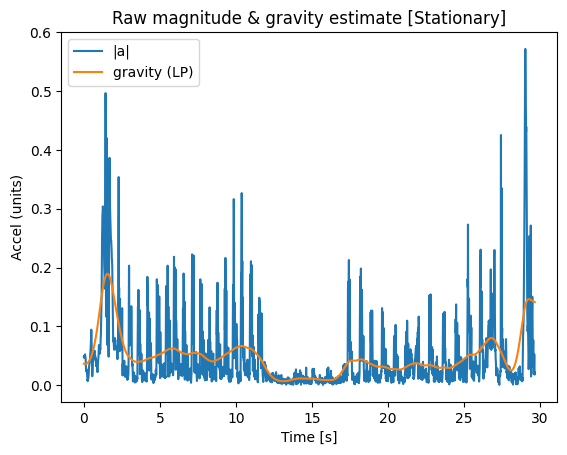

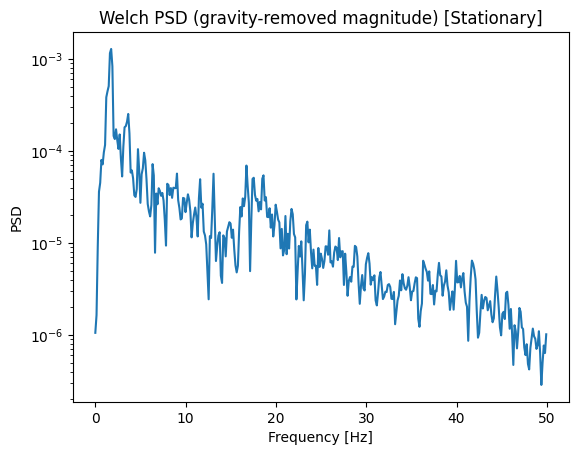

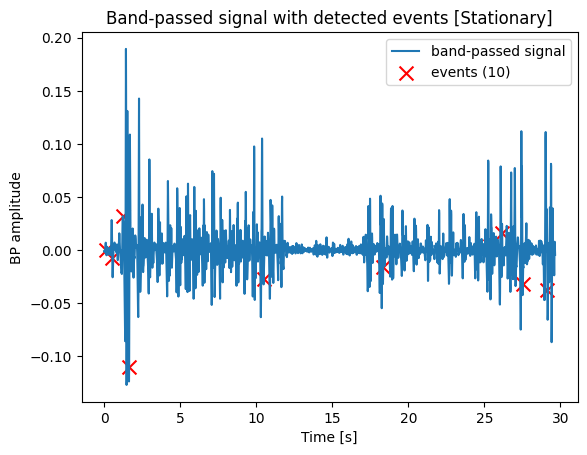

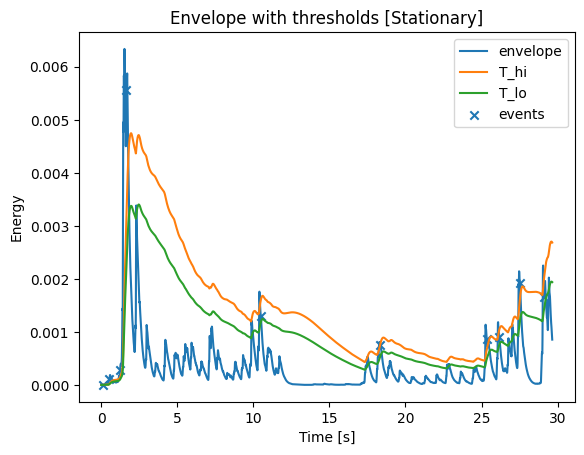

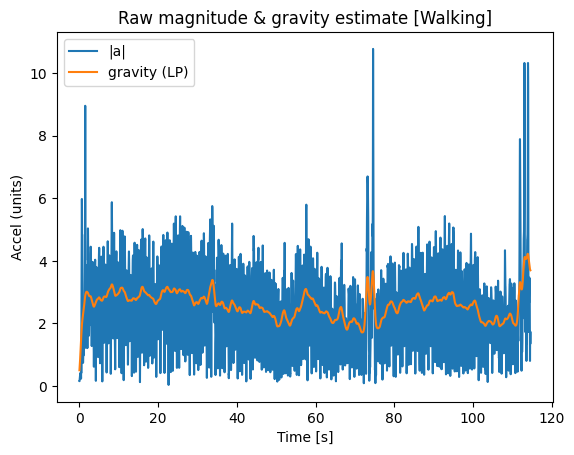

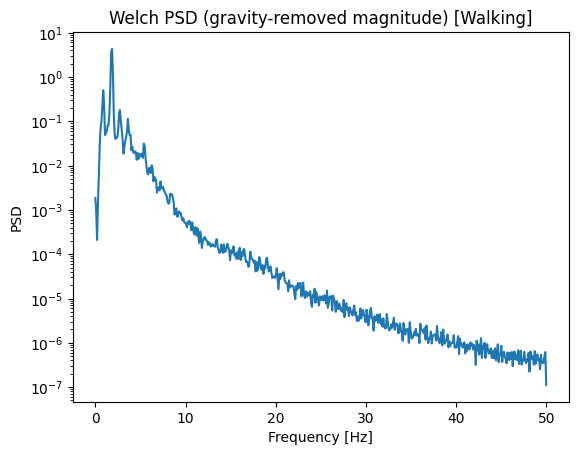

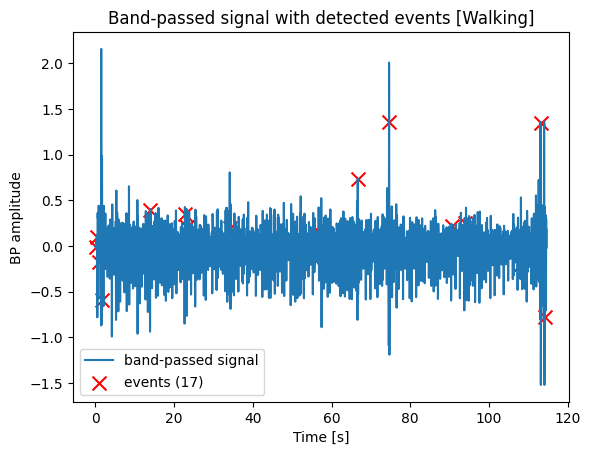

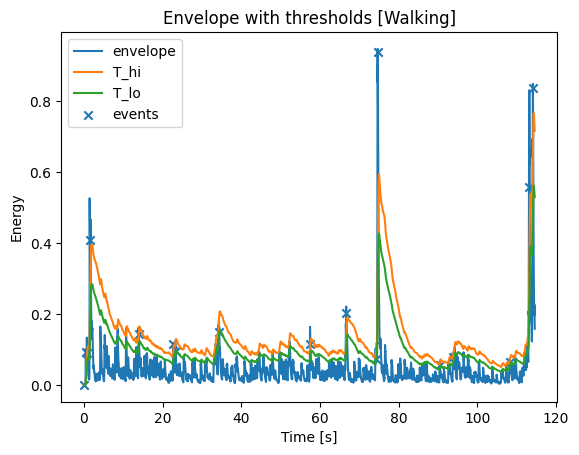

In [56]:

res_stat = run_pipeline(stationary, hp_cut=hp_cut, lp_cut=lp_cut, env_method=env_method, env_tau=env_tau, env_M=env_M,
                        tau_b=tau_b, tau_v=tau_v, k_hi=k_hi, k_lo=k_lo,
                        refractory=refractory, min_duration=min_duration, gravity_fc=gravity_fc,
                        show_plots=True, label="[Stationary]")

res_walk = run_pipeline(walking, hp_cut=hp_cut, lp_cut=lp_cut, env_method=env_method, env_tau=env_tau, env_M=env_M,
                        tau_b=tau_b, tau_v=tau_v, k_hi=k_hi, k_lo=k_lo,
                        refractory=refractory, min_duration=min_duration, gravity_fc=gravity_fc,
                        show_plots=True, label="[Walking]")

print("\nStationary summary:", res_stat["summary"])
print("Walking summary:", res_walk["summary"])


## Export detected events to CSV

In [43]:

def export_events(res, prefix):
    events = res["events_t"]
    idxs = res["events_idx"]
    df = pd.DataFrame({"sample_index": idxs, "time_sec": events})
    out = f"~/dev/zikr/dsp/{prefix}_PinchEvents.csv"
    df.to_csv(out, index=False)
    print("Wrote", out)
    return out

out1 = export_events(res_stat, "Stationary")
out2 = export_events(res_walk, "Walking")


Wrote ~/dev/zikr/dsp/Stationary_PinchEvents.csv
Wrote ~/dev/zikr/dsp/Walking_PinchEvents.csv



## Next steps / notes

- If you see false positives while walking, try increasing `hp_cut` to 5–6 Hz, or raising `k_hi` to 5.0.
- If you miss some pinches, try lowering `k_hi` to 3.0–3.5 or shortening `refractory` to 0.20 s.
- You can swap the envelope to a moving average by setting `env_method = "ma"` and choosing a window `env_M ≈ 0.2 * fs`.
- For app deployment, port the EMA-based code (O(1) memory) and the 2nd-order Butterworth biquads to your platform.
- If sampling rate varies, consider re-sampling to a fixed `fs` before filtering (not included here).


## Parameter Optimization - Find Best Settings

This cell performs a grid search over key detection parameters to find the configuration that maximizes event detection while maintaining reasonable performance.

In [57]:
import itertools
from tqdm import tqdm

def optimize_parameters(data, param_ranges, metric='max_events', show_progress=True):
    """
    Grid search over parameter combinations to optimize detection performance.
    
    Args:
        data: loaded accelerometer data from load_accel()
        param_ranges: dict of parameter name -> list of values to try
        metric: 'max_events' or 'event_rate' (events per second)
        show_progress: whether to show progress bar
    
    Returns:
        DataFrame with all combinations and their performance metrics
    """
    
    # Get parameter names and values
    param_names = list(param_ranges.keys())
    param_values = list(param_ranges.values())
    
    # Generate all combinations
    combinations = list(itertools.product(*param_values))
    
    results = []
    
    iterator = tqdm(combinations, desc="Testing parameter combinations") if show_progress else combinations
    
    for combo in iterator:
        # Create parameter dict for this combination
        params = dict(zip(param_names, combo))
        
        try:
            # Run pipeline with these parameters (no plots to speed up)
            result = run_pipeline(
                data,
                hp_cut=params.get('hp_cut', 4.0),
                lp_cut=params.get('lp_cut', 18.0),
                env_method=params.get('env_method', 'ema'),
                env_tau=params.get('env_tau', 0.2),
                tau_b=params.get('tau_b', 2.0),
                tau_v=params.get('tau_v', 2.0),
                k_hi=params.get('k_hi', 4.0),
                k_lo=params.get('k_lo', 2.5),
                refractory=params.get('refractory', 0.30),
                min_duration=params.get('min_duration', 0.10),
                gravity_fc=params.get('gravity_fc', 0.5),
                show_plots=False,
                label=""
            )
            
            # Calculate metrics
            n_events = result["summary"]["n_events"]
            duration = result["summary"]["duration_s"]
            event_rate = n_events / duration if duration > 0 else 0
            
            # Store result
            result_dict = params.copy()
            result_dict.update({
                'n_events': n_events,
                'duration_s': duration,
                'event_rate': event_rate,
                'success': True
            })
            results.append(result_dict)
            
        except Exception as e:
            # Record failed combinations
            result_dict = params.copy()
            result_dict.update({
                'n_events': 0,
                'duration_s': 0,
                'event_rate': 0,
                'success': False,
                'error': str(e)
            })
            results.append(result_dict)
    
    # Convert to DataFrame and sort by metric
    df_results = pd.DataFrame(results)
    
    if metric == 'max_events':
        df_results = df_results.sort_values('n_events', ascending=False)
    elif metric == 'event_rate':
        df_results = df_results.sort_values('event_rate', ascending=False)
    
    return df_results

# Define parameter ranges to test
param_ranges = {
    'k_hi': [2.5, 3.0, 3.5, 4.0, 4.5, 5.0],           # Detection sensitivity
    'k_lo': [1.5, 2.0, 2.5, 3.0],                      # Hysteresis gap
    'refractory': [0.15, 0.20, 0.25, 0.30, 0.35],      # Time between detections
    'min_duration': [0.05, 0.08, 0.10, 0.12],          # Minimum signal duration
    'env_tau': [0.10, 0.15, 0.20, 0.25],               # Envelope response time
    'hp_cut': [3.0, 3.5, 4.0, 4.5, 5.0],               # High-pass cutoff
}

print(f"Testing {np.prod([len(v) for v in param_ranges.values()])} parameter combinations...")
print("This may take a few minutes...")

# Run optimization on stationary data (the one with pinches)
try:
    optimization_results = optimize_parameters(stationary, param_ranges, metric='max_events')
    
    print("\n=== TOP 10 PARAMETER COMBINATIONS ===")
    print(optimization_results.head(10)[['k_hi', 'k_lo', 'refractory', 'min_duration', 'env_tau', 'hp_cut', 'n_events', 'event_rate']])
    
    # Get the best parameters
    best_params = optimization_results.iloc[0]
    print(f"\n=== BEST CONFIGURATION ===")
    print(f"Events detected: {best_params['n_events']}")
    print(f"Event rate: {best_params['event_rate']:.2f} events/sec")
    print("Optimal parameters:")
    for param in ['k_hi', 'k_lo', 'refractory', 'min_duration', 'env_tau', 'hp_cut']:
        print(f"  {param} = {best_params[param]}")
        
except NameError:
    print("Please run the data loading cells above first to load 'stationary' data")

Testing 9600 parameter combinations...
This may take a few minutes...


Testing parameter combinations: 100%|██████████| 9600/9600 [00:21<00:00, 444.41it/s]


=== TOP 10 PARAMETER COMBINATIONS ===
    k_hi  k_lo  refractory  min_duration  env_tau  hp_cut  n_events  \
0    2.5   1.5        0.15          0.05     0.10     3.0        25   
8    2.5   1.5        0.15          0.05     0.15     4.5        25   
19   2.5   1.5        0.15          0.05     0.25     5.0        25   
18   2.5   1.5        0.15          0.05     0.25     4.5        25   
16   2.5   1.5        0.15          0.05     0.25     3.5        25   
12   2.5   1.5        0.15          0.05     0.20     4.0        25   
9    2.5   1.5        0.15          0.05     0.15     5.0        25   
13   2.5   1.5        0.15          0.05     0.20     4.5        25   
7    2.5   1.5        0.15          0.05     0.15     4.0        25   
5    2.5   1.5        0.15          0.05     0.15     3.0        25   

    event_rate  
0      0.84317  
8      0.84317  
19     0.84317  
18     0.84317  
16     0.84317  
12     0.84317  
9      0.84317  
13     0.84317  
7      0.84317  
5      0.

## Test Optimized Parameters vs Defaults

=== COMPARISON: DEFAULT vs OPTIMIZED ===

1. TESTING DEFAULT PARAMETERS:

2. TESTING OPTIMIZED PARAMETERS:

=== PERFORMANCE COMPARISON ===
Default Configuration:
  Events detected: 10
  Event rate: 0.34 events/sec

Optimized Configuration:
  Events detected: 25
  Event rate: 0.84 events/sec

Improvement: +15 events (+150.0%)

=== VISUAL COMPARISON ===


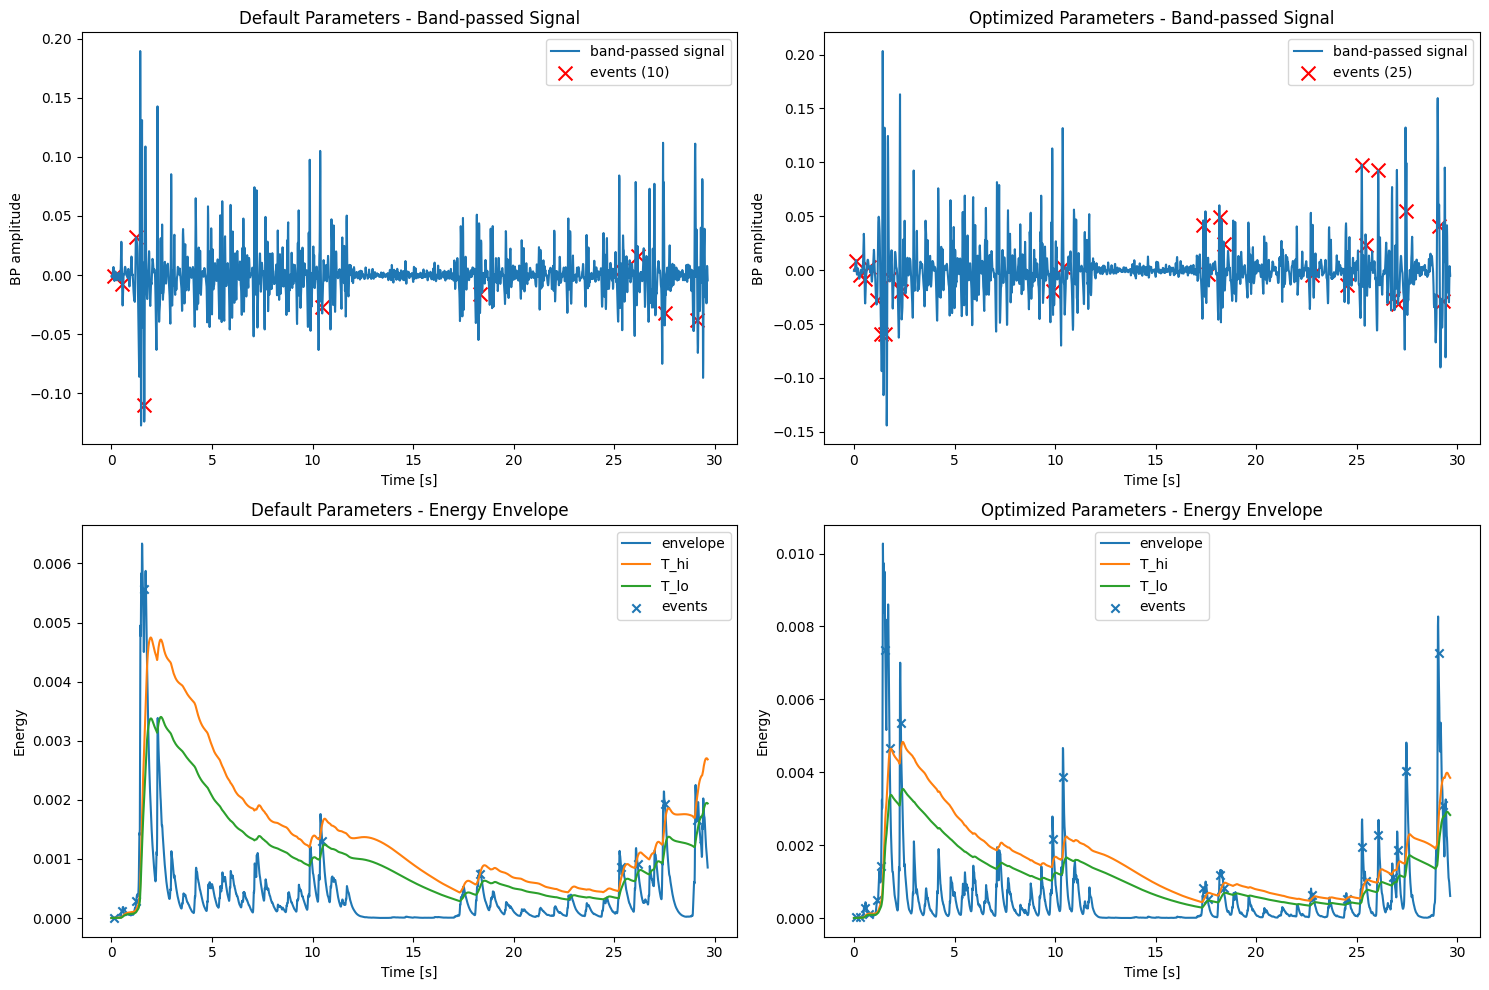

In [58]:
# Compare optimized parameters with defaults
try:
    # Extract best parameters from optimization
    best = optimization_results.iloc[0]
    
    print("=== COMPARISON: DEFAULT vs OPTIMIZED ===")
    
    # Run with default parameters
    print("\n1. TESTING DEFAULT PARAMETERS:")
    default_result = run_pipeline(
        stationary,
        hp_cut=4.0, lp_cut=18.0, env_tau=0.20,
        tau_b=2.0, tau_v=2.0, k_hi=4.0, k_lo=2.5,
        refractory=0.30, min_duration=0.10, gravity_fc=0.5,
        show_plots=False, label="[Default]"
    )
    
    # Run with optimized parameters  
    print("\n2. TESTING OPTIMIZED PARAMETERS:")
    optimized_result = run_pipeline(
        stationary,
        hp_cut=best['hp_cut'], lp_cut=18.0, env_tau=best['env_tau'],
        tau_b=2.0, tau_v=2.0, k_hi=best['k_hi'], k_lo=best['k_lo'],
        refractory=best['refractory'], min_duration=best['min_duration'], gravity_fc=0.5,
        show_plots=False, label="[Optimized]"
    )
    
    # Performance comparison
    print(f"\n=== PERFORMANCE COMPARISON ===")
    print(f"Default Configuration:")
    print(f"  Events detected: {default_result['summary']['n_events']}")
    print(f"  Event rate: {default_result['summary']['n_events']/default_result['summary']['duration_s']:.2f} events/sec")
    
    print(f"\nOptimized Configuration:")  
    print(f"  Events detected: {optimized_result['summary']['n_events']}")
    print(f"  Event rate: {optimized_result['summary']['n_events']/optimized_result['summary']['duration_s']:.2f} events/sec")
    
    improvement = optimized_result['summary']['n_events'] - default_result['summary']['n_events']
    print(f"\nImprovement: {improvement:+d} events ({improvement/default_result['summary']['n_events']*100:+.1f}%)")
    
    # Show side-by-side plots
    print(f"\n=== VISUAL COMPARISON ===")
    
    # Create side-by-side plots
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
    
    # Default results
    ax1.plot(default_result['t'], default_result['y'], label='band-passed signal')
    if len(default_result['events_t']):
        ax1.scatter(default_result['events_t'], default_result['y'][default_result['events_idx']], 
                   color='red', marker='x', s=100, label=f"events ({len(default_result['events_t'])})")
    ax1.set_title("Default Parameters - Band-passed Signal")
    ax1.set_xlabel("Time [s]")
    ax1.set_ylabel("BP amplitude")
    ax1.legend()
    
    ax3.plot(default_result['t'], default_result['e'], label='envelope')
    ax3.plot(default_result['t'], default_result['T_hi'], label='T_hi')
    ax3.plot(default_result['t'], default_result['T_lo'], label='T_lo')
    if len(default_result['events_t']):
        ax3.scatter(default_result['events_t'], default_result['e'][default_result['events_idx']], 
                   marker="x", label="events")
    ax3.set_title("Default Parameters - Energy Envelope")
    ax3.set_xlabel("Time [s]")
    ax3.set_ylabel("Energy")
    ax3.legend()
    
    # Optimized results
    ax2.plot(optimized_result['t'], optimized_result['y'], label='band-passed signal')
    if len(optimized_result['events_t']):
        ax2.scatter(optimized_result['events_t'], optimized_result['y'][optimized_result['events_idx']], 
                   color='red', marker='x', s=100, label=f"events ({len(optimized_result['events_t'])})")
    ax2.set_title("Optimized Parameters - Band-passed Signal")
    ax2.set_xlabel("Time [s]")
    ax2.set_ylabel("BP amplitude")
    ax2.legend()
    
    ax4.plot(optimized_result['t'], optimized_result['e'], label='envelope')
    ax4.plot(optimized_result['t'], optimized_result['T_hi'], label='T_hi')
    ax4.plot(optimized_result['t'], optimized_result['T_lo'], label='T_lo')
    if len(optimized_result['events_t']):
        ax4.scatter(optimized_result['events_t'], optimized_result['e'][optimized_result['events_idx']], 
                   marker="x", label="events")
    ax4.set_title("Optimized Parameters - Energy Envelope")
    ax4.set_xlabel("Time [s]")
    ax4.set_ylabel("Energy")
    ax4.legend()
    
    plt.tight_layout()
    plt.show()
    
except NameError:
    print("Run the parameter optimization cell above first")